In [1]:
import array
from array import array
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import find_peaks
import numpy as np
from math import sqrt

In [2]:
##set up the correct directory name with data
path = "CalScale28032023"

##Source 1 -> Eu152 -> energy: 40 keV, 122 keV, 244 keV, 344 keV, 778 keV, 1098 keV, 1408 keV
fileName1 = "spectrometr_LYSO_Eu152_53,98V_40dB_histo.txt"

listFiles = [fileName1]
listPhotoPeaks = [6]        #good detected peaks is 122 keV, 244 keV, 344 keV

energy, ADCcharray, errADCcharray, enRes, errenRes = np.array([]),np.array([]),np.array([]),np.array([]),np.array([])

energy = np.append(energy, 1.408)
energy = np.append(energy, 1.098)
energy = np.append(energy, 0.778)
energy = np.append(energy, 0.344)
energy = np.append(energy, 0.244)
energy = np.append(energy, 0.122)
#energy = np.append(energy, 0.040)  

##set up left X axis limit on histogram for analysis
XZoom = True
#YZoom = True
YZoom = False
Xleft = 229000.0  
Xright = 243000.0  
Ybottom = 0.
Ytop = 1000.

outSpectr = 'spectr_152Eu_LYSO.png'
outCalADCScale = 'EnergyCalibration_152Eu_LYSO.png'
outEnRes = 'EnergyResolution_152Eu_LYSO.png'

In [3]:
##determine functions for fit the data
def Gauss(x, a, x0, s):
    return a*np.exp(-((x-x0)/s)**2)

def DoubleGauss(x, a1, x01, s1, a2, x02, s2):
    return Gauss(x, a1, x01, s1) + Gauss(x, a2, x02, s2)

def nGauss(x, *p):
    n = len(p)/3
    res = 0
    for i in range(n):
        res += Gauss(x, p[i*3], p[i*3+1], p[i*3+2])
    return res

def plotAllGauss(x, p):
    n = len(p)//3
    for i in range(n):
        plt.plot(x, Gauss(x,p[i*3],p[i*3+1],p[i*3+2]), 'b', linewidth=0.5)
        
def fitline(x, A, B): 
    return A*x + B

i_peaks= [1392 1671 1977 2393 2509 2659 2753]  x[i_peaks]= [231139.732 233371.779 235819.83  239147.899 240075.918 241275.943
 242027.959]  y[i_peaks]= [   53.   153.   313.  1466.  1057.  5193. 27389.]
len(i_peaks)= 7  x_lastPeak= 242027.959
index= 0
npeaks =  6
n= 0  peak= 231139.732
0 peak: Параметры гауссианов:  [2.34842487e+01 2.31139732e+05 9.99997461e+05 1.62690789e+01
 2.31139732e+05 2.95860952e+02]
Стандартное отклонение:  8.326907767191912
Квадрат коэффициента корреляции:  0.3230075884876237
n= 1  peak= 233371.779
1 peak: Параметры гауссианов:  [9.37705465e+01 2.33371779e+05 9.99994847e+05 4.09695167e+01
 2.33371779e+05 2.80662647e+02]
Стандартное отклонение:  17.720651373928106
Квадрат коэффициента корреляции:  0.39070238422136455
n= 2  peak= 235819.83
2 peak: Параметры гауссианов:  [2.18690753e+02 2.35819830e+05 7.63460413e+05 5.67997287e+01
 2.35819830e+05 3.45092979e+02]
Стандартное отклонение:  17.091950707447097
Квадрат коэффициента корреляции:  0.5192076019729981
n= 3 

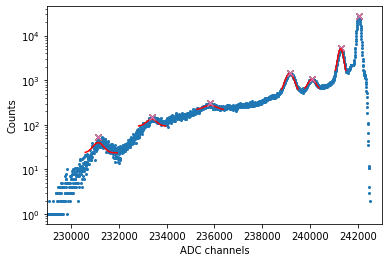

y =  -7912.226669594112 *x +  242109.98073287797


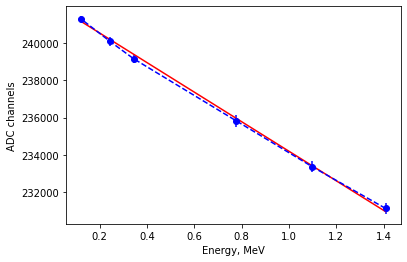

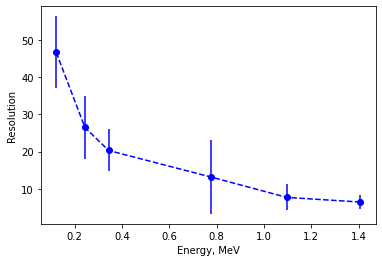

In [4]:
for fileName in listFiles:    
    x,y = np.array([]), np.array([])
    
    try:
        file1 = open(path + "/" + fileName)
        for line1 in file1.readlines():
            line1 = line1.replace(',','.')
            b = line1.split()
            b[0] = float(b[0])
            b[1] = float(b[1])
            x = np.append(x, b[0])
            y = np.append(y, b[1])
    except FileNotFoundError:
        print('Can`t open the file',fileName,'. No such file or directory')
    except ValueError:
        print('It`s not a number. Check the data in the file')
    except IndexError:
        print('The index is not in the range of elements. Check the data in the file')
    
    plt.plot(x, y,'o',markersize=2)  
    plt.xlabel('ADC channels')
    plt.ylabel('Counts')
    plt.yscale('log')
    if XZoom:
        plt.xlim([Xleft, Xright])  
    if YZoom:
        plt.ylim([Ybottom, Ytop])  

    #Find peaks
    thresh_top    = np.median(y) + 0.02 * np.std(y)
    i_peaks, _ = find_peaks(y,  height=thresh_top, width=5, distance=50)
    print('i_peaks=',i_peaks,' x[i_peaks]=',x[i_peaks],' y[i_peaks]=',y[i_peaks])
    print('len(i_peaks)=',len(i_peaks),' x_lastPeak=',x[i_peaks][len(i_peaks)-1])
    
    ##Fit peaks
    index = listFiles.index(fileName)
    npeaks = listPhotoPeaks[index]
    print('index=',index)
    print('npeaks = ',npeaks)
    
    for n in range(npeaks):
        peak = x[i_peaks][n]
        print('n=',n,' peak=',peak)    
    
        #plt.plot([min(y), max(y)], [thresh_top, thresh_top],'--',  color='r', label='peaks-threshold') # Plot threshold
        plt.plot(x[i_peaks], y[i_peaks], 'x')
    
        board1 = peak-350.
        board2 = peak+350.
        
        if n==0:
            board1 = peak-550.
            board2 = peak+800.
        if n==1:
            board1 = peak-550.
            board2 = peak+600.
        if n==2:
            board1 = peak-550.
            board2 = peak+550.
        if n==3:
            board1 = peak-350.
            board2 = peak+350.
        if n==4:
            board1 = peak-300.
            board2 = peak+300.
        if n==5:
            board1 = peak-220.
            board2 = peak+220.

        mask = (x>board1) & (x<board2)
        x1 = x[mask]
        y1 = y[mask]

        init_valsp = [.025, peak-100, 30., .025, peak-100, 30.]
        p, cov = curve_fit(DoubleGauss, x1, y1, p0=init_valsp, bounds=(0, [50000., peak, 1000000., 50000., peak, 1000000.]))
        fit_y = DoubleGauss(x1, *p)    
        print(n, "peak: Параметры гауссианов: ",p)
        #print(n, "peak: Covariance matrix: ",cov)
        #оценка погрешности аппроксимации и достоверности модели
        print("Стандартное отклонение: ", np.std(y1-fit_y))
        slope, ic, r_value, p_value, std_err = stats.linregress(y1,fit_y)
        print("Квадрат коэффициента корреляции: ", r_value**2)
        dp = \
          [np.sqrt(cov[j,j]) for j in range(p.size)]

        plt.plot(x1, fit_y, 'r')

        sigma = p[5]
        errsigma = dp[5]
        mean = p[4]
        errmean = dp[4]
        if p[2]<p[5]:
            sigma = p[2]        
            errsigma = dp[2]        
            mean = p[1]
            errmean = dp[1]
            
        ADCcharray = np.append(ADCcharray, mean)
        errADCcharray = np.append(errADCcharray, sigma)       
        enRes = np.append(enRes, 2.36*sigma*100./(x[i_peaks][len(i_peaks)-1]-mean))
        errenRes = np.append(errenRes, ((x[i_peaks][len(i_peaks)-1]-mean)*2.36*errsigma*100. + 2.36*sigma*100.*errmean)/(x[i_peaks][len(i_peaks)-1]-mean)**2)
        #print('mean=',mean,'+-',errmean,'sigma=',sigma,'+-',errsigma)
        
    plt.savefig(str(index) + outSpectr)    
    plt.show() 
    
plt.errorbar(energy, ADCcharray, yerr=errADCcharray, fmt='ob--')
popt, pcov = curve_fit(fitline, energy, ADCcharray, sigma = errADCcharray)
print('y = ',popt[0],'*x + ',popt[1])
fit_l = fitline(energy, *popt)
plt.plot(energy, fit_l, 'r')
plt.xlabel('Energy, MeV')
plt.ylabel('ADC channels')
plt.savefig(outCalADCScale)
plt.show()

plt.errorbar(energy, enRes, yerr=errenRes, fmt='ob--')
plt.xlabel('Energy, MeV')
plt.ylabel('Resolution')
plt.savefig(outEnRes)
plt.show()
